In [2]:
# Verify GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


GPU Available: False
GPU Name: None


In [3]:
import multiprocessing
print("Number of CPU cores available:", multiprocessing.cpu_count())


Number of CPU cores available: 8


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [5]:
import pandas as pd
file_path = "/content/crime2017-2024.csv"
data = pd.read_csv(file_path)

In [6]:
data.shape

(1873724, 28)

In [7]:
data.describe()

,ID,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Hour,Day_of_Week,Month,Is_Weekend,ZIP,Encoded_Crime_Type,Encoded_Crime_Severity
count,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06,1.873724e+06
mean,1.215516e+07,1.147337e+03,1.124433e+01,2.321368e+01,3.664712e+01,2.020315e+03,4.184437e+01,-8.766956e+01,1.280075e+01,3.014927e+00,6.447097e+00,2.878791e-01,6.063012e+04,4.379877e+00,1.211313e+00
std,1.028359e+06,7.018405e+02,7.012646e+00,1.399502e+01,2.151354e+01,2.294717e+00,8.679418e-02,5.916682e-02,6.729624e+00,2.000023e+00,3.326482e+00,4.527746e-01,2.118626e+01,2.025574e+00,9.423750e-01
min,2.305900e+04,1.110000e+02,1.000000e+00,1.000000e+00,1.000000e+00,2.017000e+03,4.164459e+01,-8.793973e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,6.060100e+04,0.000000e+00,0.000000e+00
25%,1.146572e+07,6.110000e+02,6.000000e+00,1.000000e+01,2.300000e+01,2.018000e+03,4.176885e+01,-8.771164e+01,8.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,6.061700e+04,3.000000e+00,0.000000e+00
50%,1.216674e+07,1.031000e+03,1.000000e+01,2.400000e+01,3.200000e+01,2.020000e+03,4.186290e+01,-8.766303e+01,1.400000e+01,3.000000e+00,6.000000e+00,0.000000e+00,6.062600e+04,3.000000e+00,2.000000e+00
75%,1.289810e+07,1.723000e+03,1.700000e+01,3.400000e+01,5.300000e+01,2.022000e+03,4.190706e+01,-8.762742e+01,1.800000e+01,5.000000e+00,9.000000e+00,1.000000e+00,6.064200e+04,7.000000e+00,2.000000e+00
max,1.359903e+07,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,2.024000e+03,4.202267e+01,-8.752453e+01,2.300000e+01,6.000000e+00,1.200000e+01,1.000000e+00,6.082700e+04,7.000000e+00,2.000000e+00


In [8]:
print(data.shape, data.columns)

(1873724, 28) Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward',
       'Community Area', 'FBI Code', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Hour', 'Day_of_Week', 'Month', 'Is_Weekend',
       'Time_of_Day', 'ZIP', 'Consolidated_Type', 'Encoded_Crime_Type',
       'Crime_Severity', 'Encoded_Crime_Severity'],
      dtype='object')


## Predictive Modeling _ crime Likelihood

In [9]:
# Define group columns for spatial and temporal aggregation
group_cols = ['ZIP', 'Hour', 'Day_of_Week', 'Month']

# Create crime count as a proxy for likelihood
data['Crime_Count'] = data.groupby(group_cols)['ID'].transform('count')

# Optional: Create a binary likelihood target
threshold = data['Crime_Count'].mean()  # Use the mean count as a threshold
data['Crime_Likelihood'] = (data['Crime_Count'] > threshold).astype(int)

# Use 'Crime_Likelihood' as the new target
target = 'Crime_Likelihood'


In [10]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
# Ensure all features are numeric and properly encoded
categorical_cols = ['FBI Code', 'Primary Type', 'Description', 'Time_of_Day', 'Consolidated_Type', 'Crime_Severity']
for col in categorical_cols:
    data[col] = data[col].astype(str)  # Ensure all values are strings
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Encode strings to numeric

# Drop irrelevant or redundant features
drop_cols = ['Case Number', 'Block', 'Date', 'Updated On']  # Adjust as needed
data = data.drop(columns=drop_cols)

# Convert boolean features to integers
data['Arrest'] = data['Arrest'].astype(int)
data['Domestic'] = data['Domestic'].astype(int)

In [23]:
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.model_selection import train_test_split, cross_val_score
# # Ensure all features are numeric and properly encoded
# categorical_cols = ['FBI Code', 'Primary Type', 'Description', 'Time_of_Day', 'Consolidated_Type', 'Crime_Severity']
# for col in categorical_cols:
#     data[col] = data[col].astype(str)  # Ensure all values are strings
#     le = LabelEncoder()
#     data[col] = le.fit_transform(data[col])  # Encode strings to numeric

# # Drop irrelevant or redundant features
# drop_cols = ['Case Number', 'Block', 'Date', 'Updated On']  # Adjust as needed
# data = data.drop(columns=drop_cols)

# # Convert boolean features to integers
# data['Arrest'] = data['Arrest'].astype(int)
# data['Domestic'] = data['Domestic'].astype(int)

# # # Handle numeric conversions and drop invalid rows
# # data = data.apply(pd.to_numeric, errors='coerce')
# # data = data.dropna()


# # Define target and refined features
# target = 'Crime_Likelihood'
# features = [
#     'Latitude', 'Longitude',  'Beat', 'Community Area',
#     'District', 'Hour', 'ZIP', 'Ward', 'Day_of_Week', 'Month'
# ]

# # Split data into train/test sets
# X = data[features]
# y = (data['Crime_Count'] > data['Crime_Count'].mean()).astype(int)  # Binary target for likelihood
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Random Forest Model
# rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf_model.fit(X_train, y_train)
# rf_predictions = rf_model.predict(X_test)
# print("Random Forest Classification Report:")
# print(classification_report(y_test, rf_predictions))

# # Logistic Regression
# log_reg = LogisticRegression(max_iter=500, random_state=42)
# log_reg.fit(X_train, y_train)
# log_predictions = log_reg.predict(X_test)
# print("Logistic Regression Classification Report:")
# print(classification_report(y_test, log_predictions))

# # XGBoost Classifier
# xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
# xgb_model.fit(X_train, y_train)
# xgb_predictions = xgb_model.predict(X_test)
# print("XGBoost Classification Report:")
# print(classification_report(y_test, xgb_predictions))

# # Compare Cross-Validation Scores
# rf_cv = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
# log_cv = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy')
# xgb_cv = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# print(f"Random Forest CV Accuracy: {rf_cv.mean():.4f}")
# print(f"Logistic Regression CV Accuracy: {log_cv.mean():.4f}")
# print(f"XGBoost CV Accuracy: {xgb_cv.mean():.4f}")

# # Mutual Information
# mi_scores = mutual_info_classif(X, y, random_state=42)
# mi_df = pd.DataFrame({'Feature': features, 'Mutual Information': mi_scores})
# mi_df.sort_values(by='Mutual Information', ascending=False, inplace=True)

# # Plot Mutual Information
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Mutual Information', y='Feature', data=mi_df, palette='coolwarm')
# plt.title('Mutual Information Scores')
# plt.show()


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    202670
           1       0.95      0.95      0.95    172075

    accuracy                           0.96    374745
   macro avg       0.96      0.96      0.96    374745
weighted avg       0.96      0.96      0.96    374745

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74    202670
           1       0.70      0.67      0.69    172075

    accuracy                           0.72    374745
   macro avg       0.72      0.72      0.72    374745
weighted avg       0.72      0.72      0.72    374745

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92    202670
           1       0.90      0.90      0.90    172075

    accuracy                           0.91    374745
   macro avg     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Random Forest CV Accuracy: 0.9568
Logistic Regression CV Accuracy: 0.6476
XGBoost CV Accuracy: 0.9088


<ipython-input-11-81494d0a9da2>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance, palette='viridis')


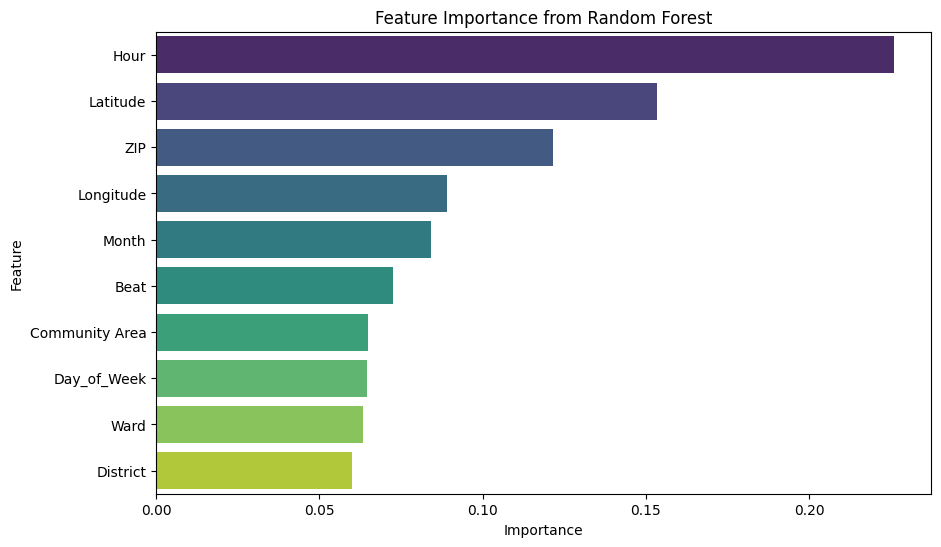

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
# Define target and refined feature set (excluding Crime_Count)
target = 'Crime_Likelihood'
features = ['Latitude', 'Longitude', 'ZIP', 'Beat', 'Community Area', 'District', 'Hour', 'Ward', 'Day_of_Week', 'Month']

# Ensure no data leakage from target
data['Crime_Likelihood'] = (data['Crime_Count'] > data['Crime_Count'].mean()).astype(int)
X = data[features]
y = data['Crime_Likelihood']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 1. Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# 2. Logistic Regression with Regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(max_iter=500, random_state=42, penalty='l2')
log_reg.fit(X_train_scaled, y_train)
log_predictions = log_reg.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_predictions))

# 3. XGBoost Model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
log_cv_scores = cross_val_score(log_reg, X, y, cv=cv, scoring='accuracy')
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='accuracy')

print(f"Random Forest CV Accuracy: {np.mean(rf_cv_scores):.4f}")
print(f"Logistic Regression CV Accuracy: {np.mean(log_cv_scores):.4f}")
print(f"XGBoost CV Accuracy: {np.mean(xgb_cv_scores):.4f}")

# Feature Importance from Random Forest
rf_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
rf_importance.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.show()

### Fine tune the random forest model

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Subsample data
X_subsample, _, y_subsample, _ = train_test_split(X_train, y_train, test_size=0.7, stratify=y_train, random_state=42)

# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=1)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of combinations to try
    scoring='accuracy',
    cv=3,  # Fewer folds
    n_jobs=2,
    verbose=2,
    random_state=42
)
random_search.fit(X_subsample, y_subsample)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Evaluate the final model
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Best Score: 0.9114862791856343
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    202670
           1       0.91      0.90      0.91    172075

    accuracy                           0.92    374745
   macro avg       0.91      0.91      0.91    374745
weighted avg       0.91      0.92      0.91    374745



In [ ]:
import joblib
joblib.dump(grid_search, "grid_search_results.pkl")


In [ ]:
best_params = grid_search.best_params_  # or random_search.best_params_
rf_final = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)

print(classification_report(y_test, y_pred))


In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Initialize SHAP Explainer for Random Forest
explainer_rf = shap.TreeExplainer(best_rf_model)
shap_values_rf = explainer_rf.shap_values(X_train)

# Feature Importance based on SHAP values (global interpretation)
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

# Summary plot to show the contribution of features (detailed)
shap.summary_plot(shap_values_rf, X_train)

# Explanation for a single prediction (local interpretation)
sample_idx = 0  # Index of the sample to explain
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][sample_idx], X_train.iloc[sample_idx], matplotlib=True)


## Saptial Modeling- Crime Type


### Feature selection code

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873724 entries, 0 to 1873723
Data columns (total 25 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   ID                      int64  
 1   IUCR                    object 
 2   Primary Type            int64  
 3   Description             int64  
 4   Arrest                  int64  
 5   Domestic                int64  
 6   Beat                    int64  
 7   District                float64
 8   Ward                    float64
 9   Community Area          float64
 10  Year                    int64  
 11  Latitude                float64
 12  Longitude               float64
 13  Hour                    int64  
 14  Day_of_Week             int64  
 15  Month                   int64  
 16  Is_Weekend              int64  
 17  Time_of_Day             int64  
 18  ZIP                     float64
 19  Consolidated_Type       int64  
 20  Encoded_Crime_Type      int64  
 21  Crime_Severity          int64  

In [ ]:
# Convert problematic string features
string_cols = ['FBI Code', 'Primary Type', 'Description', 'Time_of_Day', 'Consolidated_Type', 'Crime_Severity']
for col in string_cols:
    data[col] = data[col].astype(str)  # Ensure string type
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])  # Encode strings to numeric
  #Drop irrelevant or redundant features
drop_cols = ['Case Number', 'Block', 'Date', 'Updated On', 'FBI Code']  # Dropping 'FBI Code'
data = data.drop(columns=drop_cols)

# Convert boolean features to integers
data['Arrest'] = data['Arrest'].astype(int)
data['Domestic'] = data['Domestic'].astype(int)

<ipython-input-27-94ec9dedaf25>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


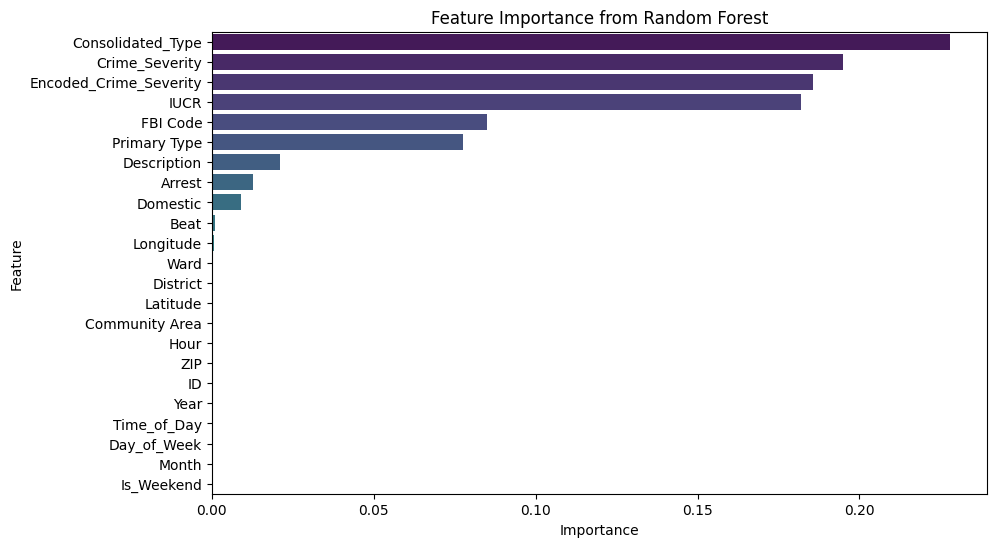

In [ ]:
# Define target and features
target = 'Encoded_Crime_Type'  # Adjust if the target is different
features = [col for col in data.columns if col != target]

# 1. Feature Importance with Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(data[features], data[target])

# Get feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.show()


In [ ]:
final_features = [
    'Consolidated_Type', 'Crime_Severity', 'Encoded_Crime_Severity',
    'FBI Code', 'Primary Type', 'IUCR', 'Description', 'Arrest',
    'Domestic', 'Spatial_Cluster'
]


<ipython-input-28-696b04160d9e>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


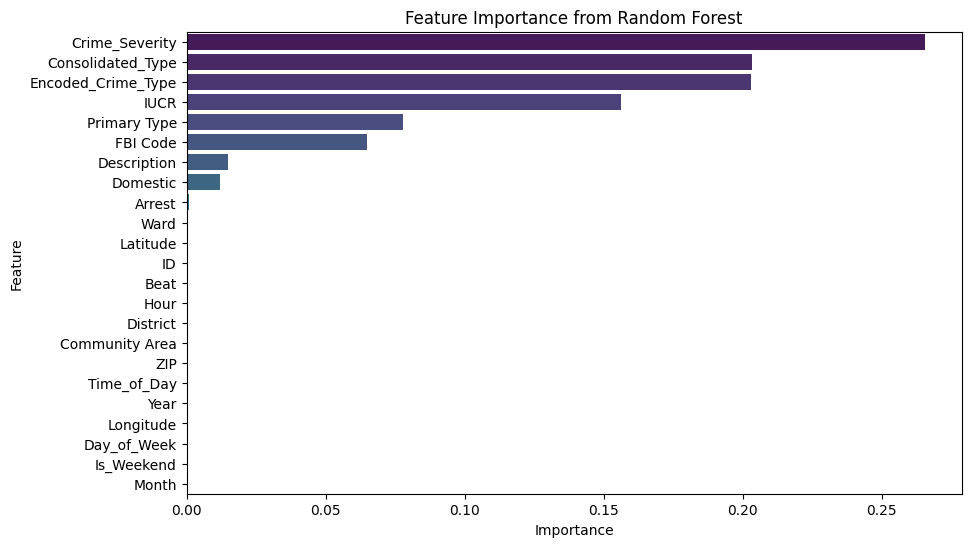

In [ ]:
# Define target and features
target = 'Encoded_Crime_Severity'  # Adjust if the target is different
features = [col for col in data.columns if col != target]

# 1. Feature Importance with Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(data[features], data[target])

# Get feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.show()


In [ ]:
# Define target and features
target = 'Crime_Likelihood'  # Adjust if the target is different
features = [col for col in data.columns if col != target]

# 1. Feature Importance with Random Forest
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(data[features], data[target])

# Get feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.show()
